In [1]:
'''Retrieve all inputs executed in the current kernel section'''
%history

'''Retrieve all inputs executed in the current kernel section'''
%history


In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import warnings

In [3]:
print('Pandas version -> %s' % pd.__version__)
print('Numpy version -> %s' % np.__version__)
print('Seaborn version -> %s' % sns.__version__)

Pandas version -> 2.1.2
Numpy version -> 1.26.1
Seaborn version -> 0.13.0


In [4]:
df_sales_data = pd.read_csv('sales_data_cleaned.csv', index_col='Unnamed: 0',
                                    dtype={  'InvoiceDate': 'string',
                                             'InvoiceMonth': 'category',
                                             'DayPart': 'category',
                                             'InvoiceNo': 'category',
                                             'CustomerID': 'string',
                                             'Country': 'category',
                                             'StockCode': 'category',
                                             'Quantity': 'int64',
                                             'UnitPrice': 'float64',
                                             'Revenue': 'float64'},
                                    parse_dates=['InvoiceDate'])

In [5]:
df_sales_data.head()

,InvoiceDate,InvoiceMonth,DayPart,InvoiceNo,CustomerID,Country,StockCode,Quantity,UnitPrice,Revenue
0,2010-12-01,2010-12,Morning,536365,17850,United Kingdom,85123A,6,2.55,15.30
1,2010-12-01,2010-12,Morning,536365,17850,United Kingdom,71053,6,3.39,20.34
2,2010-12-01,2010-12,Morning,536365,17850,United Kingdom,84406B,8,2.75,22.00
3,2010-12-01,2010-12,Morning,536365,17850,United Kingdom,84029G,6,3.39,20.34
4,2010-12-01,2010-12,Morning,536365,17850,United Kingdom,84029E,6,3.39,20.34


In [6]:
# the data was cleaned in another notebook
df_sales_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392688 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceDate   392688 non-null  datetime64[ns]
 1   InvoiceMonth  392688 non-null  category      
 2   DayPart       392688 non-null  category      
 3   InvoiceNo     392688 non-null  category      
 4   CustomerID    392688 non-null  string        
 5   Country       392688 non-null  category      
 6   StockCode     392688 non-null  category      
 7   Quantity      392688 non-null  int64         
 8   UnitPrice     392688 non-null  float64       
 9   Revenue       392688 non-null  float64       
dtypes: category(5), datetime64[ns](1), float64(2), int64(1), string(1)
memory usage: 21.4 MB


In [7]:
#RFM scores
df_rfm = pd.read_csv('customer_rfm.csv', index_col='Unnamed: 0',
                        dtype={ 'CustomerID': 'string',
                                'Frequency': 'int64',
                                'Recency': 'int64',
                                'Monetary': 'float64',
                                'r_score': 'int64',
                                'f_score': 'int64',
                                'm_score': 'int64',                               
                                'RFM': 'int64'})

In [8]:
# Color palette to keep the following plots harmonic
colors = sns.color_palette("tab20", 20)
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [9]:
# Group sales data by InvoiceNo and sum up the Revenue for each InvoiceNo
df_revenue_percentile = df_sales_data.groupby('InvoiceNo',as_index=False,observed=True)['Revenue'].sum()
 
# Filter out invoices where the Revenue is greater than the 95th percentile
df_revenue_percentile = df_revenue_percentile[
                        df_revenue_percentile['Revenue'] <= df_revenue_percentile['Revenue'].quantile(0.95)]

# Merge the filtered InvoiceNo back with the original sales data to retain other columns for those invoices
df_revenue_modelling = pd.merge(df_revenue_percentile['InvoiceNo'],
                                df_sales_data[['InvoiceNo','InvoiceDate','CustomerID',
                                               'Country','StockCode','Quantity','Revenue']],
                                on='InvoiceNo')

# Drop the InvoiceNo column as it is no longer needed
df_revenue_modelling.drop('InvoiceNo', axis=1, inplace = True)

# Merge the RFM scores based on CustomerID to the revenue modeling data
df_revenue_modelling = pd.merge(df_revenue_modelling[['InvoiceDate','CustomerID','Country','StockCode','Quantity','Revenue']],
                                df_rfm[['CustomerID','RFM']],
                                how='left',on='CustomerID')

# Group by InvoiceDate, CustomerID, Country, StockCode, and RFM, summing up Quantity and Revenue
df_revenue_modelling = df_revenue_modelling.groupby(['InvoiceDate','CustomerID','Country','StockCode','RFM'],
                                as_index=False, observed=True)[['Quantity','Revenue']].sum()

# Print the number of rows before and after the processing
print(f' Number of initial rows: {len(df_sales_data):,}\n',
        f'Number of final rows: {len(df_revenue_modelling):,}\n'
        f' Number of rows removed: {(len(df_sales_data) - len(df_revenue_modelling)):,}')

 Number of initial rows: 392,688
 Number of final rows: 345,265
 Number of rows removed: 47,423


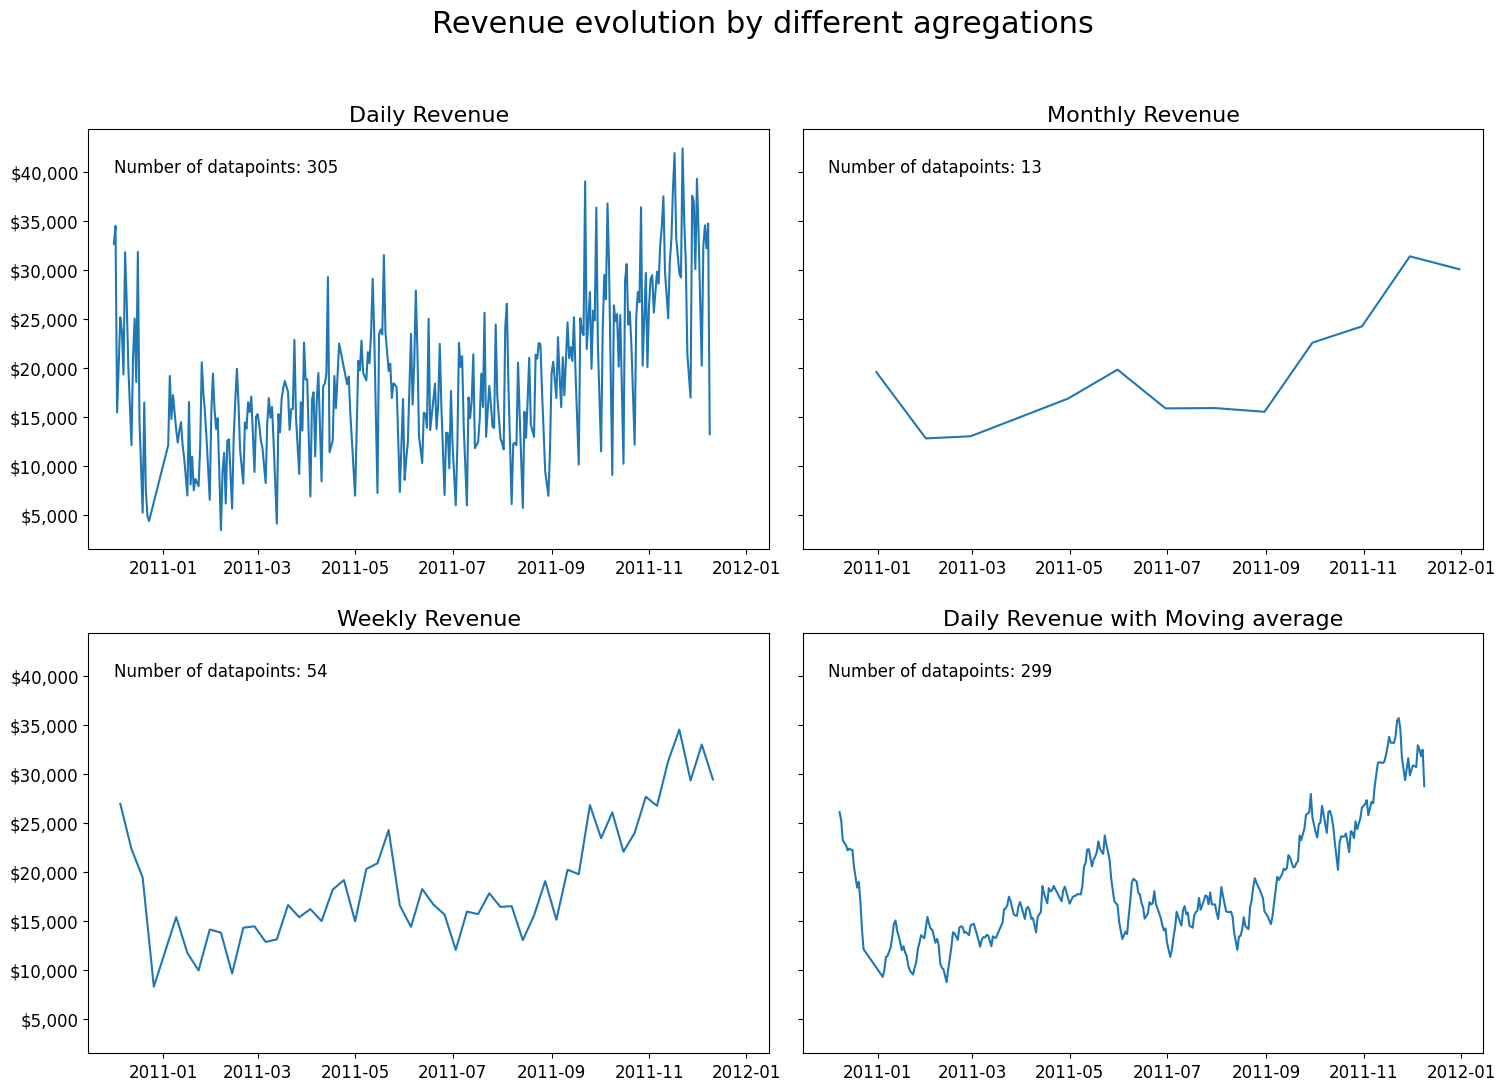

In [10]:
# Plot a figure showing the LTV distribution
warnings.filterwarnings('ignore')

fig, axs = plt.subplot_mosaic([['upperL', 'upperR',],
                               ['lowerL', 'lowerR']],
                               #sharex=True,
                               sharey=True,
                               figsize=(18, 12))

df_daily = df_revenue_modelling.groupby('InvoiceDate')[['Revenue']].sum()
df_monthly = df_daily.resample('M').mean()
df_weekly = df_daily.resample('W').mean()
df_moving_avg = df_daily.rolling(window=7).mean()
df_moving_avg = df_moving_avg[df_moving_avg['Revenue'].notnull()]

txt1 = 'Number of datapoints: ' + f'{len(df_daily):,}'
txt2 = 'Number of datapoints: ' + f'{len(df_monthly):,}'
txt3 = 'Number of datapoints: ' + f'{len(df_weekly):,}'
txt4 = 'Number of datapoints: ' + f'{len(df_moving_avg):,}'
texts = [txt1,txt2,txt3,txt4]

# Plot graphs
sns.lineplot(df_daily['Revenue'],color=colors[0], ax=axs['upperL'])
sns.lineplot(df_monthly['Revenue'],color=colors[0],ax=axs['upperR'])
sns.lineplot(df_weekly['Revenue'],color=colors[0], ax=axs['lowerL'])
sns.lineplot(df_moving_avg['Revenue'],color=colors[0], ax=axs['lowerR'])

i=0
for plot in ['upperL', 'upperR', 'lowerL', 'lowerR']:
    axs[plot].set_xlim(pd.to_datetime('2010-11-15', format = '%Y-%m-%d'),pd.to_datetime('2012-01-15', format = '%Y-%m-%d'))
    axs[plot].text(pd.to_datetime('2010-12-01', format = '%Y-%m-%d'),40000,texts[i], fontsize = 12)
    i += 1

# Edit axis    
for plot in ['upperL', 'upperR', 'lowerL', 'lowerR']:
    axs[plot].set(xlabel=None)
    axs[plot].set(ylabel=None)
    vals = axs[plot].get_yticks()
    axs[plot].xaxis.set_tick_params(labelsize = 12)
    axs[plot].set_yticklabels([f'${x:,.0f}' for x in vals], fontsize = 12)
    
# Add titles to figure and each column    
fig.suptitle('Revenue evolution by different agregations', fontsize = 22)
axs['upperL'].set_title('Daily Revenue', fontsize=16)
axs['upperR'].set_title('Monthly Revenue', fontsize=16)
axs['lowerL'].set_title('Weekly Revenue', fontsize=16)
axs['lowerR'].set_title('Daily Revenue with Moving average', fontsize=16)

# Adjust the spacing between the plots
fig.subplots_adjust(wspace=0.05, hspace=0.2)

plt.show()
        
warnings.filterwarnings('default')

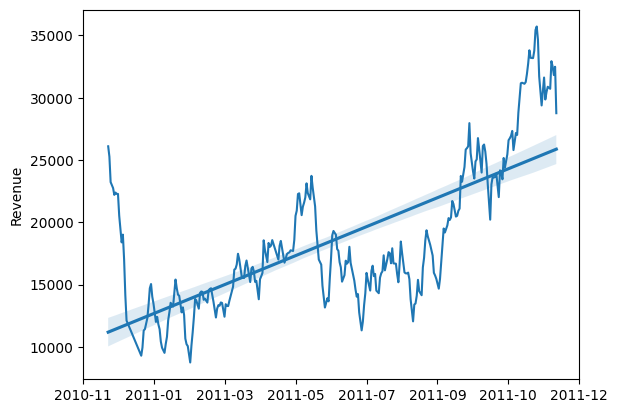

In [11]:
# Plot a figure showing the LTV trend
ax1 = sns.lineplot(data=df_moving_avg,
             x=df_moving_avg.index.values.astype(np.int64) // 10 ** 9,
             y='Revenue',
             color=colors[0])

sns.regplot(data=df_moving_avg,
                  x=df_moving_avg.index.values.astype(np.int64) // 10 ** 9,
                  y='Revenue',
                  color=colors[0],
                  scatter_kws={'s': 7},
                  label='Linear Model',
                  scatter=False,
                  ax = ax1).plot(x_compat=True)

# convert the axis back to datetime
xticks = ax1.get_xticks()
labels = [pd.to_datetime(label*10 ** 9).to_period('M') for label in xticks]
ax1.set_xticks(xticks)
ax1.set_xticklabels(labels)

plt.show()

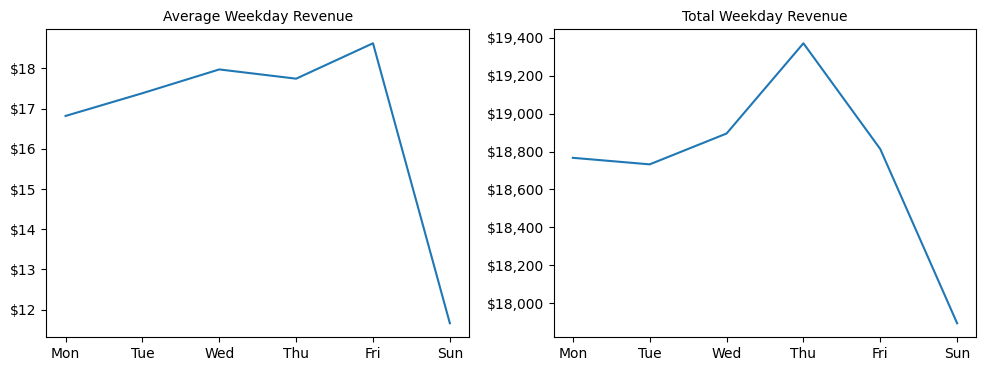

In [12]:
# Plot a figure showing the weekly seasonality
fig, axs = plt.subplot_mosaic([['Left', 'Right']],
                               #sharex=True,
                               #sharey=True,
                               figsize=(12, 4))

df_weekday = df_revenue_modelling.set_index('InvoiceDate')
df_weekday['Weekday'] = [x for x in df_weekday.index.day_of_week]
df_weekday['WeekdayName'] = [x.strftime('%a') for x in df_weekday.index]
df_weekday_avg = df_weekday.groupby(['Weekday','WeekdayName'],as_index=False)[['Revenue']].mean()
sns.lineplot(x='WeekdayName',y='Revenue',data=df_weekday_avg,color=colors[0], ax=axs['Left'])

df_weekday = df_moving_avg
df_weekday['Weekday'] = [x for x in df_weekday.index.day_of_week]
df_weekday['WeekdayName'] = [x.strftime('%a') for x in df_weekday.index]
df_weekday_sum = df_weekday.groupby(['Weekday','WeekdayName'],as_index=False)[['Revenue']].mean()
sns.lineplot(x='WeekdayName',y='Revenue',data=df_weekday_sum,color=colors[0],ax=axs['Right'])

# Edit axis    
warnings.filterwarnings('ignore')
for plot in ['Left', 'Right']:
    axs[plot].set(xlabel=None)
    axs[plot].set(ylabel=None)
    vals = axs[plot].get_yticks()
    axs[plot].xaxis.set_tick_params(labelsize = 10)
    axs[plot].set_yticklabels([f'${x:,.0f}' for x in vals], fontsize = 10)
warnings.filterwarnings('default')

# Add titles to figure and each column    
axs['Left'].set_title('Average Weekday Revenue', fontsize=10)
axs['Right'].set_title('Total Weekday Revenue', fontsize=10)

plt.show()

We have a somehow positive trend and a weekly seasonality

In [13]:
# creating a new dataframe
df_modelling = df_moving_avg.drop(['Weekday','WeekdayName'],axis=1)

In [14]:
# Perform Augmented Dickey-Fuller test to check the stationarity of my data
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_modelling['Revenue'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
#Data is not stationary

ADF Statistic: -0.465347
p-value: 0.898603
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572


In [15]:
#Perform KPSS test for stationary
from statsmodels.tsa.stattools import kpss

# Perform KPSS test
warnings.filterwarnings('ignore')
kpss_result = kpss(df_modelling['Revenue'])
kpss_statistic = kpss_result[0]
kpss_pvalue = kpss_result[1]
kpss_critical_values = kpss_result[3]
warnings.filterwarnings('default')

print('KPSS Statistic: ', kpss_statistic)
print('KPSS PValue: ', kpss_pvalue)

#Data is not stationary

KPSS Statistic:  1.6387734200113513
KPSS PValue:  0.01


Text(0, 0.5, 'Residual')

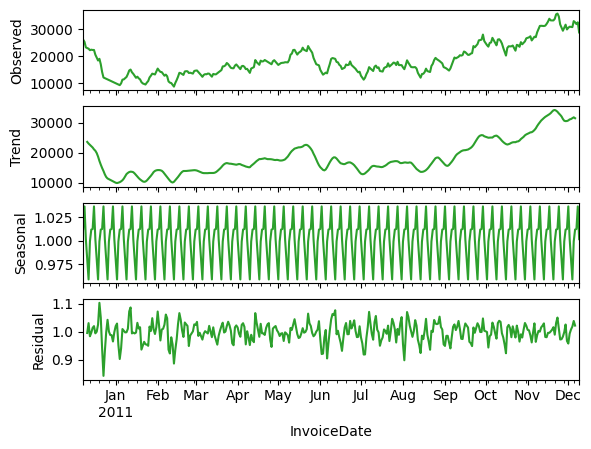

In [16]:
#Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
df_modelling = df_modelling.reset_index()
df_modelling['InvoiceDate'] = pd.to_datetime(df_modelling['InvoiceDate'])
df_modelling = df_modelling.set_index('InvoiceDate').asfreq('D')
df_modelling.sort_index(inplace=True)

df_modelling = df_modelling.interpolate(limit_area='inside')

result = seasonal_decompose(df_modelling['Revenue'], model='multiplicative')

fig, axes = plt.subplots(4, 1, sharex=True)

result.observed.plot(ax=axes[0], legend=False, color=colors[4])
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False, color=colors[4])
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False, color=colors[4])
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False, color=colors[4])
axes[3].set_ylabel('Residual')

In [17]:
# Perform the Augmented Dickey-Fuller test on the 'Revenue' column of the dataframe
result = adfuller(df_modelling['Revenue'])
print('Original results:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Compute the first difference of the 'Revenue' column to make the series stationary
df_modelling_diff = df_modelling['Revenue'].diff().to_frame()
df_modelling_diff.rename(columns={'Revenue': 'diff_Revenue'}, inplace=True)
df_modelling_diff = df_modelling_diff[df_modelling_diff['diff_Revenue'].notnull()]

# Perform the ADF test again on the differenced data
result = adfuller(df_modelling_diff['diff_Revenue'])
print('\nResults after one differenciation:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

Original results:
ADF Statistic: -0.579846
p-value: 0.875471

Results after one differenciation:
ADF Statistic: -5.782783
p-value: 0.000001


<Axes: xlabel='InvoiceDate', ylabel='Revenue'>

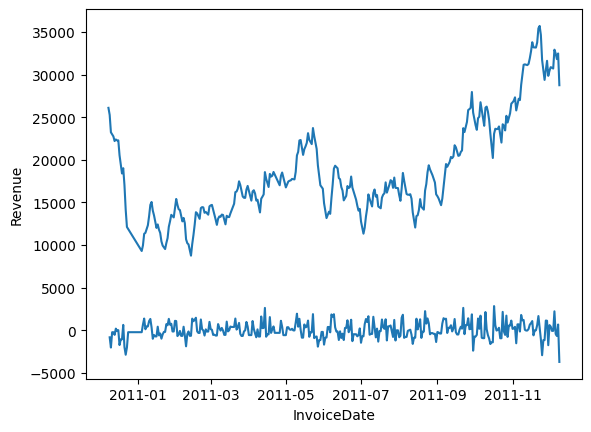

In [18]:
# Plot the original 'Revenue' time series using seaborn lineplot
ax = sns.lineplot(x=df_modelling.index,y='Revenue',data=df_modelling,color=colors[0])

# Plot the differenced 'Revenue' time series on the same axes as the original plot
sns.lineplot(x=df_modelling_diff.index,y='diff_Revenue',data=df_modelling_diff,color=colors[0], ax = ax)

In [19]:
# Convert the 'InvoiceDate' column to datetime format
# Interpolate missing values in 'diff_Revenue' column
df_modelling_diff = df_modelling_diff.reset_index()
df_modelling_diff['InvoiceDate'] = pd.to_datetime(df_modelling_diff['InvoiceDate'])
df_modelling_diff = df_modelling_diff.set_index('InvoiceDate').asfreq('D').sort_index()
df_modelling_diff['diff_Revenue'] = df_modelling_diff['diff_Revenue'].interpolate(method='time')

In [20]:
# Train/test split
df_modelling_train = df_modelling_diff[df_modelling_diff.index <= '2011-11-08']
df_modelling_test = df_modelling_diff[df_modelling_diff.index >= '2011-11-09']

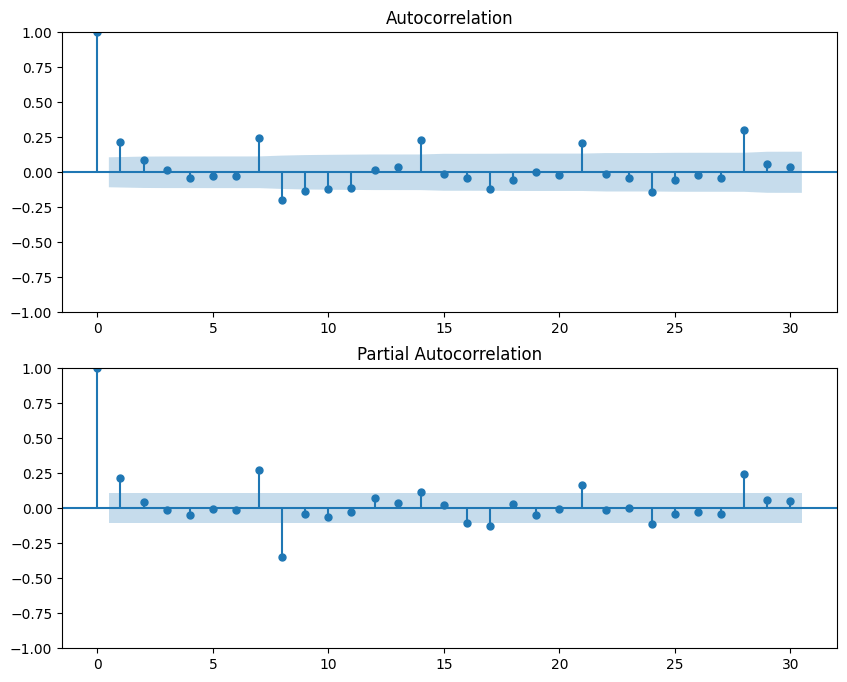

In [21]:
# Plot the Autocorrelation Function (ACF) for the series with 30 lags
# Plot the Partial Autocorrelation Function (PACF) for the series with 30 lags
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

series = df_modelling_train['diff_Revenue']

fig, ax = plt.subplots(2, figsize=(10,8))
ax[0] = plot_acf(series, ax=ax[0], lags=30)
ax[1] = plot_pacf(series, ax=ax[1], lags=30)
plt.show()

In [22]:
# Define the ARIMA model with specified order (p,d,q) = (7,0,7)
from statsmodels.tsa.arima.model import ARIMA

series = df_modelling_train['diff_Revenue']

model = ARIMA(series, order=(7,0,7))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           diff_Revenue   No. Observations:                  335
Model:                 ARIMA(7, 0, 7)   Log Likelihood               -2693.021
Date:                Thu, 30 May 2024   AIC                           5418.043
Time:                        11:11:35   BIC                           5479.069
Sample:                    12-09-2010   HQIC                          5442.372
                         - 11-08-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0558     93.001      0.087      0.931    -174.222     190.334
ar.L1         -0.3767      0.140     -2.690      0.007      -0.651      -0.102
ar.L2         -0.3759      0.149     -2.519      0.0

C:\Users\natferna5\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
# Generate predictions for the test data period
start_index = len(series)
predict = model_fit.predict(len(df_modelling_train),len(df_modelling_train)+len(df_modelling_test)-1)

# Convert the predictions to a DataFrame and rename the column to 'Predicted_Revenue'
df_predict = predict.to_frame().rename(columns={'predicted_mean': 'Predicted_Revenue'})

In [24]:
# Evaluate model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

model_mean = df_modelling_test['diff_Revenue'].mean()
mae = mean_absolute_error(df_modelling_test['diff_Revenue'], df_predict)
mse = mean_squared_error(df_modelling_test['diff_Revenue'], df_predict)
rmse = np.sqrt(mse)

print('Mean Revenue: %i' % model_mean)

print('Mean Absolute Error: %i' % mae)
print('Root Mean Squared Error: %i' % rmse)

print('Relative Mean Absolute Error: %.2f%%' % ((mae / model_mean)*100))
print('Relativve Root Mean Squared Error: %.2f%%' % ((rmse / model_mean)*100))

Mean Revenue: -1
Mean Absolute Error: 874
Root Mean Squared Error: 1138
Relative Mean Absolute Error: -65021.04%
Relativve Root Mean Squared Error: -84616.61%


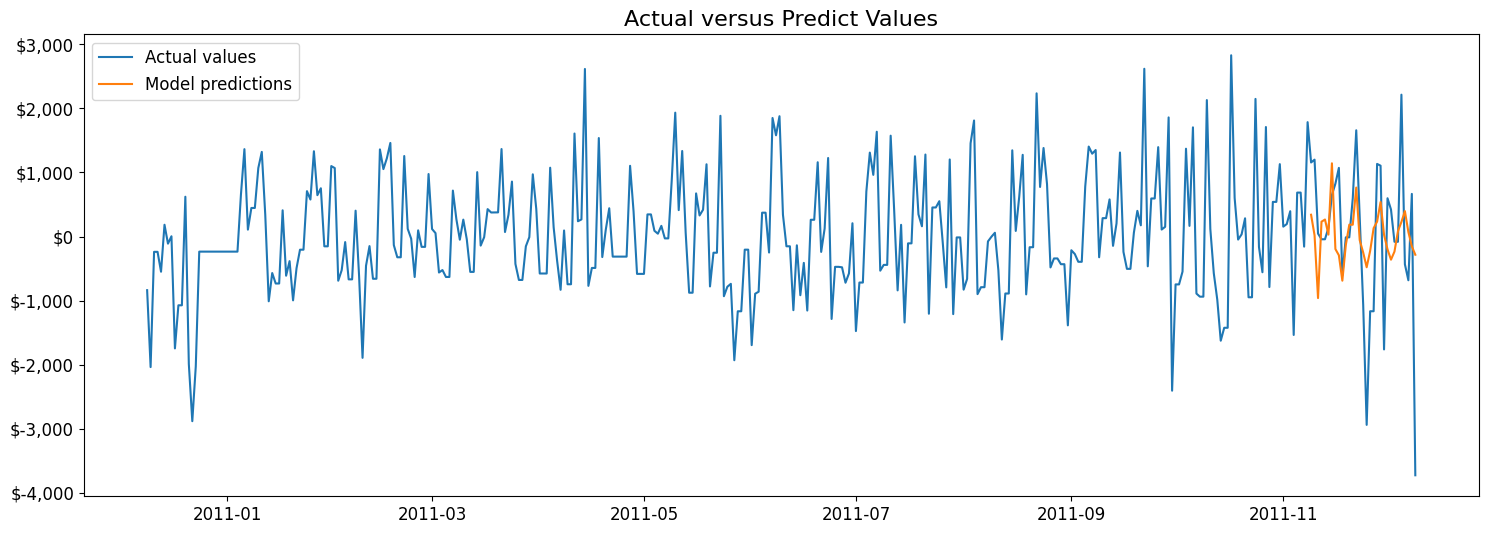

In [25]:
# Plot model prediction. 
fig, ax = plt.subplots(figsize=(18, 6))

warnings.filterwarnings('ignore')

sns.lineplot(df_modelling_diff['diff_Revenue'], label='Actual values', color=colors[0], ax=ax)
sns.lineplot(df_predict['Predicted_Revenue'], label='Model predictions', color=colors[2], ax=ax)

ax.set_title('Actual versus Predict Values',fontsize=16)
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.xaxis.set_tick_params(labelsize = 12)
vals = ax.get_yticks()
ax.set_yticklabels([f'${x:,.0f}' for x in vals], fontsize = 12)
ax.legend(fontsize=12)

warnings.filterwarnings('default')

plt.show()

In [26]:
# Let's use the SARIMAX Model instead
# Train/test split
df_modelling_train = df_modelling[df_modelling.index <= '2011-11-08']
df_modelling_test = df_modelling[df_modelling.index >= '2011-11-09']

In [29]:
# Auto_arima to choose the model parameters
from pmdarima.arima import auto_arima

model = auto_arima(df_modelling_train['Revenue'], 
                   seasonal=True, 
                   m=12,  # frequency of series
                   d=1,   # let model determine 'd'
                   D=1,   # let model determine 'D'
                   start_p=0, 
                   start_q=0, 
                   start_P=0, 
                   start_Q=0,
                   max_p=10, 
                   max_q=10, 
                   max_P=10, 
                   max_Q=10,
                   trace=True, 
                   error_action='ignore', 
                   suppress_warnings=True, 
                   stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5525.921, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5471.922, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5428.327, Time=1.58 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5505.103, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=1.57 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=3.83 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5468.355, Time=0.80 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=3.56 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5433.237, Time=0.73 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5430.086, Time=2.07 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=5430.135, Time=2.07 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=5428.114, Time=1.45 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5505.721, Time=0.10 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.61 sec
 ARIMA(1,1,0)(0,1,2)[12]             : 

In [32]:
# Creating a SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df_modelling_train['Revenue'], order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))

model_fit = model.fit(disp=False)

predict = model_fit.predict(len(df_modelling_train),len(df_modelling_train)+len(df_modelling_test)-1)

df_predict = predict.to_frame().rename(columns={'predicted_mean': 'Revenue'})

In [33]:
# Evaluate model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error

model_mean = df_modelling_test['Revenue'].mean()
mae = mean_absolute_error(df_modelling_test, df_predict)
mse = mean_squared_error(df_modelling_test, df_predict)
rmse = np.sqrt(mse)

print('Mean Revenue: %i' % model_mean)

print('Mean Absolute Error: %i' % mae)
print('Root Mean Squared Error: %i' % rmse)

print('Relative Mean Absolute Error: %.2f%%' % ((mae / model_mean)*100))
print('Relativve Root Mean Squared Error: %.2f%%' % ((rmse / model_mean)*100))

Mean Revenue: 31883
Mean Absolute Error: 1971
Root Mean Squared Error: 2283
Relative Mean Absolute Error: 6.18%
Relativve Root Mean Squared Error: 7.16%


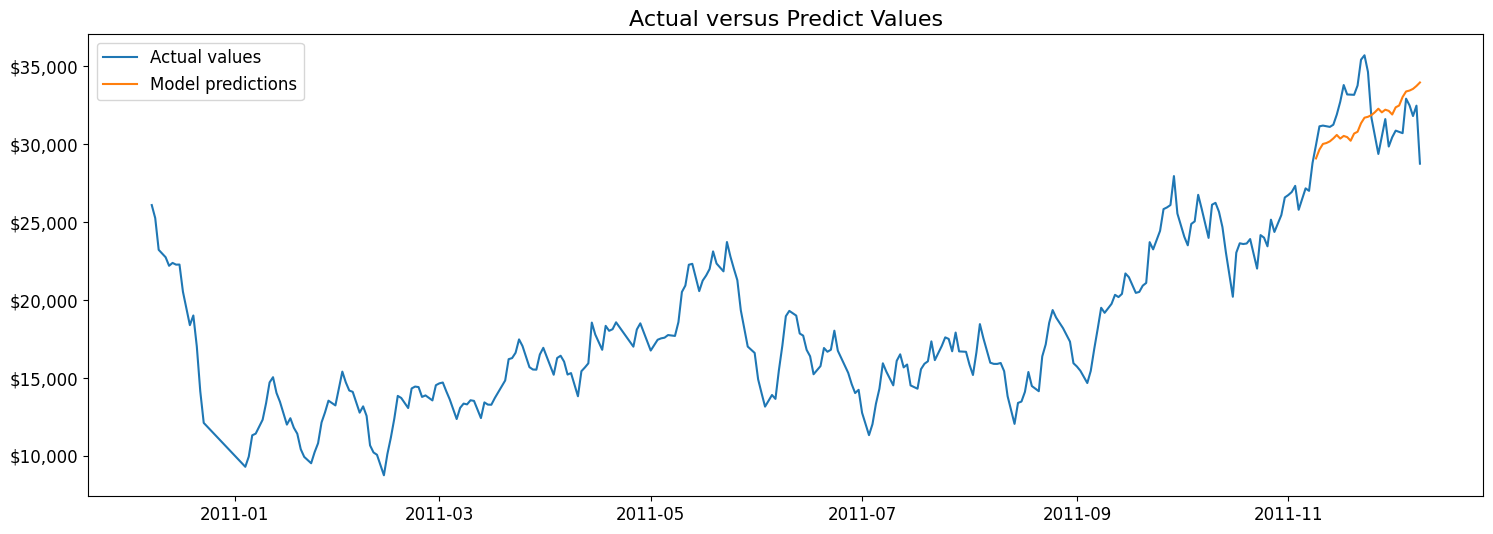

In [34]:
# Plot model prediction. 
fig, ax = plt.subplots(figsize=(18, 6))

warnings.filterwarnings('ignore')

sns.lineplot(df_moving_avg['Revenue'], label='Actual values', color=colors[0], ax=ax)
sns.lineplot(df_predict['Revenue'], label='Model predictions', color=colors[2], ax=ax)

ax.set_title('Actual versus Predict Values',fontsize=16)
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.xaxis.set_tick_params(labelsize = 12)
vals = ax.get_yticks()
ax.set_yticklabels([f'${x:,.0f}' for x in vals], fontsize = 12)
ax.legend(fontsize=12)

warnings.filterwarnings('default')

plt.show()

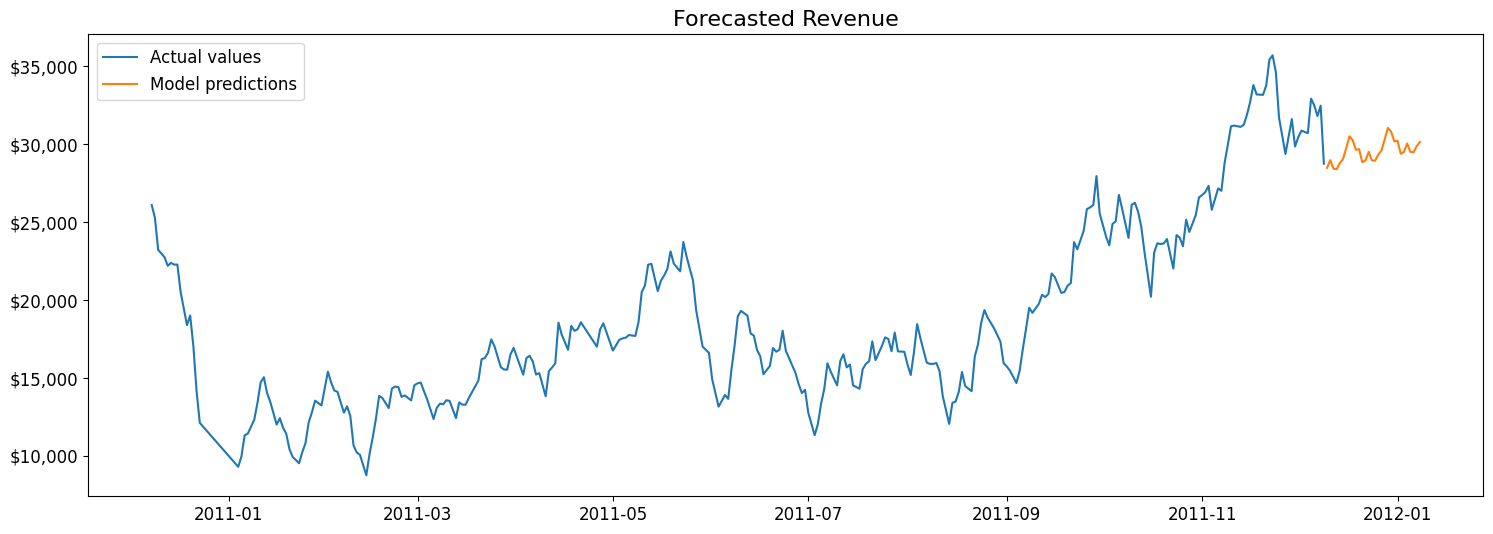

In [35]:
# Plot model forecast. 
model = SARIMAX(df_modelling['Revenue'], order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))

model_fit = model.fit(disp=False)

forecast = model_fit.forecast(steps=30)
df_forecast = forecast.to_frame().rename(columns={'predicted_mean': 'Revenue'})

fig, ax = plt.subplots(figsize=(18, 6))

warnings.filterwarnings('ignore')

sns.lineplot(df_moving_avg['Revenue'], label='Actual values', color=colors[0], ax=ax)
sns.lineplot(df_forecast['Revenue'], label='Model predictions', color=colors[2], ax=ax)

ax.set_title('Forecasted Revenue',fontsize=16)
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.xaxis.set_tick_params(labelsize = 12)
vals = ax.get_yticks()
ax.set_yticklabels([f'${x:,.0f}' for x in vals], fontsize = 12)
ax.legend(fontsize=12)

warnings.filterwarnings('default')

plt.show()